# 1. Predicting Flight Arrival Delays (Machine Learning)

#### Importing Necessary Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pulp
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImblearnPipeline
from sklearn.cluster import KMeans
from datetime import datetime

#### Importing Input Data Files

In [2]:
data = pd.read_csv('filtered_flight_data.csv')
pd.set_option('display.max_columns', None)

In [3]:
data.shape[1]

29

In [4]:
data.head()

,FL_DATE,OP_CARRIER_AIRLINE_ID,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 28
0,2018-08-01,21167,N201NN,6005,12892,1289208,32575,LAX,14893,1489302,33192,SMF,700,653.0,-7.0,0.0,824.0,-4.0,0.0,0.0,NaN,88.0,91.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-08-01,21167,N201NN,6005,14893,1489302,33192,SMF,12892,1289208,32575,LAX,900,851.0,-9.0,0.0,1038.0,-8.0,0.0,0.0,NaN,106.0,107.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-08-01,21167,N218NN,6010,12892,1289208,32575,LAX,14893,1489302,33192,SMF,1110,1104.0,-6.0,0.0,1227.0,-13.0,0.0,0.0,NaN,90.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-08-01,21167,N218NN,6010,14893,1489302,33192,SMF,12892,1289208,32575,LAX,1310,1305.0,-5.0,0.0,1436.0,-12.0,0.0,0.0,NaN,98.0,91.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-08-01,21167,N209NN,6011,12892,1289208,32575,LAX,14831,1483106,32457,SJC,705,704.0,-1.0,0.0,816.0,0.0,0.0,0.0,NaN,71.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN


<hr style="border:0.5px solid #000"/>

#### Filtering to keep only Relevant Input Features

In [5]:
# Uncomment the next lines and modify the list of relevant columns as needed
relevant_columns = [
    'FL_DATE', 
    'OP_CARRIER_AIRLINE_ID', 
#    'TAIL_NUM', 
#    'OP_CARRIER_FL_NUM',
#    'ORIGIN_AIRPORT_ID', 
#    'ORIGIN_AIRPORT_SEQ_ID', 
#    'ORIGIN_CITY_MARKET_ID', 
    'ORIGIN',
#    'DEST_AIRPORT_ID', 
#     'DEST_AIRPORT_SEQ_ID', 
#     'DEST_CITY_MARKET_ID', 
    'DEST',
#    'CRS_DEP_TIME', 
    'DEP_TIME', 
#    'DEP_DELAY', 
#     'DEP_DELAY_NEW', 
    'ARR_TIME',
    'ARR_DELAY', 
#    'ARR_DELAY_NEW', 
    'CANCELLED', 
    'CANCELLATION_CODE', 
#    'CRS_ELAPSED_TIME',
#    'ACTUAL_ELAPSED_TIME', 
    'CARRIER_DELAY', 
    'WEATHER_DELAY', 
    'NAS_DELAY',
    'SECURITY_DELAY', 
    'LATE_AIRCRAFT_DELAY'
]
data = data[relevant_columns]

# To check the reduced dataframe
data.head()

,FL_DATE,OP_CARRIER_AIRLINE_ID,ORIGIN,DEST,DEP_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2018-08-01,21167,LAX,SMF,653.0,824.0,-4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-08-01,21167,SMF,LAX,851.0,1038.0,-8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-08-01,21167,LAX,SMF,1104.0,1227.0,-13.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-08-01,21167,SMF,LAX,1305.0,1436.0,-12.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-08-01,21167,LAX,SJC,704.0,816.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


<hr style="border:0.5px solid #000"/>

#### Null Treatment

In [6]:
data.shape[0]

20311

In [7]:
null_counts = data.isnull().sum().sort_values(ascending=False)
print(null_counts)

CANCELLATION_CODE        19841
CARRIER_DELAY            16225
WEATHER_DELAY            16225
NAS_DELAY                16225
SECURITY_DELAY           16225
LATE_AIRCRAFT_DELAY      16225
ARR_DELAY                  480
ARR_TIME                   477
DEP_TIME                   466
FL_DATE                      0
OP_CARRIER_AIRLINE_ID        0
ORIGIN                       0
DEST                         0
CANCELLED                    0
dtype: int64


#### Dropping the fields with a higher proportion of null records

In [8]:
# List of columns to drop
columns_to_drop = ['CANCELLATION_CODE', 'LATE_AIRCRAFT_DELAY', 'SECURITY_DELAY', 
                   'NAS_DELAY', 'WEATHER_DELAY', 'CARRIER_DELAY']

# Dropping the specified columns
data = data.drop(columns=columns_to_drop)

# Dropping rows with any null values
data = data.dropna()

In [9]:
null_counts = data.isnull().sum().sort_values(ascending=False)
print(null_counts)

FL_DATE                  0
OP_CARRIER_AIRLINE_ID    0
ORIGIN                   0
DEST                     0
DEP_TIME                 0
ARR_TIME                 0
ARR_DELAY                0
CANCELLED                0
dtype: int64


<hr style="border:0.5px solid #000"/>

#### Correlation Check

/var/folders/48/3359jr0n34v6fd5jftvl2dn00000gn/T/ipykernel_62474/2497433749.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


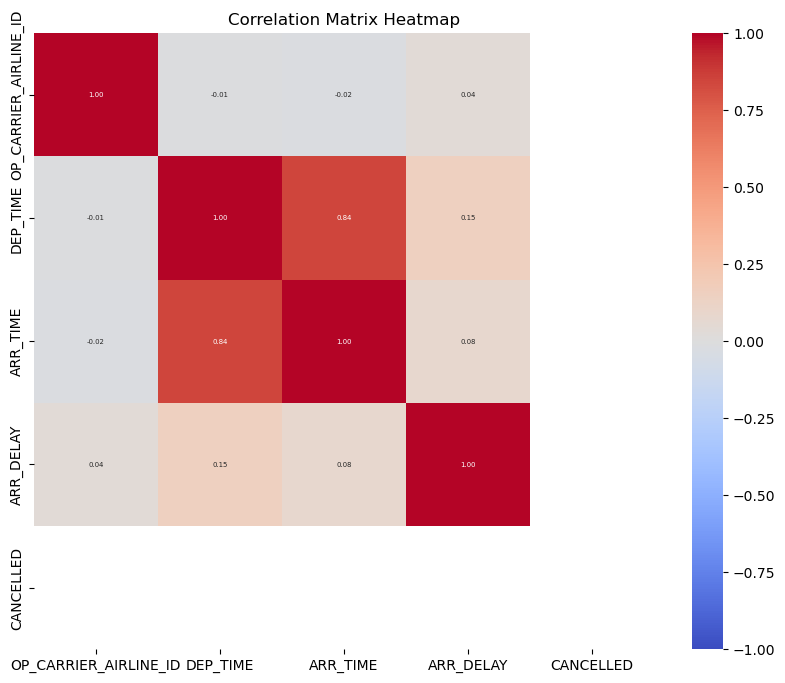

In [10]:
# Calculate the correlation matrix
corr = data.corr()

# Plot the heatmap with smaller annotation font size
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 5})
plt.title('Correlation Matrix Heatmap')
plt.show()

In [11]:
# Find pairs of fields with high correlation
high_corr = (corr.abs() > 0.8) & (corr.abs() < 1.0)
high_corr_pairs = high_corr.unstack().dropna()

# Filter out lower/upper triangular duplicates by sorting
unique_corr_pairs = high_corr_pairs.sort_values(ascending=False).drop_duplicates()

print("Pairs of fields with a correlation greater than 0.8:")
print(unique_corr_pairs[unique_corr_pairs > 0.8])

Pairs of fields with a correlation greater than 0.8:
DEP_TIME  ARR_TIME    True
dtype: bool


Departure time and arrival time show the highest correlation which aligns well with the business context as well.

<hr style="border:0.5px solid #000"/>

#### Analyzing variability of Arrival Delays 

In [12]:
# Display the minimum value of 'ARR_DELAY'
min_ARR_DELAY = data['ARR_DELAY'].min()
print(f"Minimum ARR_DELAY: {min_ARR_DELAY}")

# Display the maximum value of 'ARR_DELAY'
max_ARR_DELAY = data['ARR_DELAY'].max()
print(f"Maximum ARR_DELAY: {max_ARR_DELAY}")

# Display the range of 'ARR_DELAY'
range_ARR_DELAY = max_ARR_DELAY - min_ARR_DELAY
print(f"Range of ARR_DELAY: {range_ARR_DELAY}")

# Display the mean value of 'ARR_DELAY'
mean_ARR_DELAY = data['ARR_DELAY'].mean()
print(f"Mean ARR_DELAY: {mean_ARR_DELAY}")

# Display the median value of 'ARR_DELAY'
median_ARR_DELAY = data['ARR_DELAY'].median()
print(f"Median ARR_DELAY: {median_ARR_DELAY}")

# Display the mode value of 'ARR_DELAY' (Note: mode() returns a Series, so we extract the value)
mode_ARR_DELAY = data['ARR_DELAY'].mode()[0]
print(f"Mode ARR_DELAY: {mode_ARR_DELAY}")

# Display the standard deviation of 'ARR_DELAY'
std_dev_ARR_DELAY = data['ARR_DELAY'].std()
print(f"Standard Deviation of ARR_DELAY: {std_dev_ARR_DELAY}")

Minimum ARR_DELAY: -44.0
Maximum ARR_DELAY: 1298.0
Range of ARR_DELAY: 1342.0
Mean ARR_DELAY: 7.400685794967475
Median ARR_DELAY: -4.0
Mode ARR_DELAY: -8.0
Standard Deviation of ARR_DELAY: 40.99176463708514


<hr style="border:0.5px solid #000"/>

### Feature Engineering, Data Preprocessing and Model Building

In [13]:
# 'data' is the DataFrame loaded with flight data
df = data

# Feature Engineering: Creating new features based on existing data
# Function to categorize departure time into parts of the day
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

# Extract hour from DEP_TIME and apply the function to categorize time of day
df['DEP_HOUR'] = (df['DEP_TIME'] // 100).astype(int)  # Extract hour from HHMM format
df['TIME_OF_DAY'] = df['DEP_HOUR'].apply(get_time_of_day)

# Extract the month from the flight date for capturing seasonal effects
df['MONTH'] = pd.to_datetime(df['FL_DATE']).dt.month

# Create a binary target variable for delay (1 if there's a delay, 0 otherwise)
df['Delay'] = (df['ARR_DELAY'] > 0).astype(int)

# Prepare feature matrix and target vector
# Including newly created features and categorical features
feature_columns = ['OP_CARRIER_AIRLINE_ID', 'DEP_HOUR', 'CANCELLED', 'TIME_OF_DAY', 'MONTH', 'ORIGIN', 'DEST']
categorical_features = ['ORIGIN', 'DEST', 'TIME_OF_DAY', 'MONTH']
df[categorical_features] = df[categorical_features].apply(LabelEncoder().fit_transform)

# Define X and y for model training
X = df[feature_columns]
y = df['Delay']

# Data preprocessing and ML pipeline
# Configure preprocessing to scale numerical data
preprocessor = ColumnTransformer(transformers=[('scaler', StandardScaler(), feature_columns)], remainder='passthrough')

# Setup the machine learning pipeline with SMOTE for handling class imbalance
pipeline = ImblearnPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  # SMOTE for synthetic minority oversampling
    ('classifier', GradientBoostingClassifier(random_state=42))  # Gradient Boosting Classifier
])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Setup grid search to find the best hyperparameters
param_grid = {
    'classifier__n_estimators': [100, 150, 200],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.15],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__subsample': [0.75, 0.8, 0.9, 1.0]
}
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Evaluate the model using test data
y_pred = grid_search.predict(X_test)
y_proba = grid_search.predict_proba(X_test)[:, 1]

# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

# Print results
print(f"Updated Accuracy: {accuracy}")
print(f"Updated ROC AUC: {roc_auc}")
print("Updated Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Cross-validation metrics for model robustness
cv_accuracy = cross_val_score(grid_search.best_estimator_, X, y, scoring='accuracy', cv=3)
cv_roc_auc = cross_val_score(grid_search.best_estimator_, X, y, scoring='roc_auc', cv=3)

print(f"Updated CV Accuracy: {np.mean(cv_accuracy)} ± {np.std(cv_accuracy)}")
print(f"Updated CV ROC AUC: {np.mean(cv_roc_auc)} ± {np.std(cv_roc_auc)}")

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Updated Accuracy: 0.7101083942525838
Updated ROC AUC: 0.768515976002607
Updated Confusion Matrix:
[[1822  598]
 [ 552  995]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      2420
           1       0.62      0.64      0.63      1547

    accuracy                           0.71      3967
   macro avg       0.70      0.70      0.70      3967
weighted avg       0.71      0.71      0.71      3967

Updated CV Accuracy: 0.6754583754684443 ± 0.01070218415118806
Updated CV ROC AUC: 0.7264861496878314 ± 0.010291304054470166


#### Model Performance Overview:

#### Confusion Matrix Analysis:

#### Classification Report Insights:

#### Cross-Validation Metrics:

#### Looking at the Feature Importance Plot

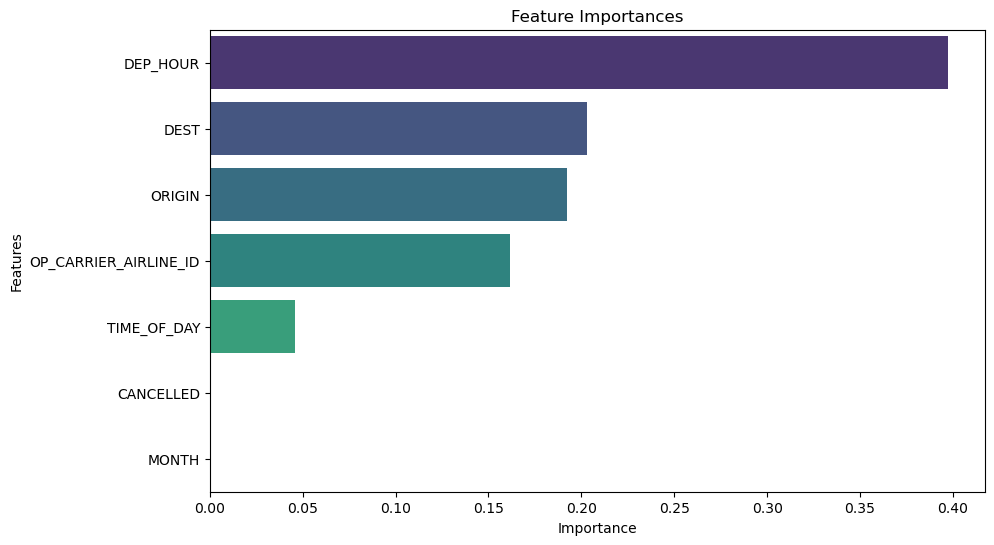

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Retrieve the best estimator from the grid search
best_model = grid_search.best_estimator_

# Extract the Gradient Boosting Classifier from the pipeline (assuming it's the last step)
gb_classifier = best_model.named_steps['classifier']

# Get feature importances
importances = gb_classifier.feature_importances_

# Create a DataFrame to view the feature importances alongside their corresponding feature names
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

<hr style="border:4px solid #000"/>

# 2. Airport Profiling Using Clustering (Machine Learning)

/var/folders/48/3359jr0n34v6fd5jftvl2dn00000gn/T/ipykernel_62474/996812784.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_data_filtered.fillna(0, inplace=True)  # Handling missing values by assuming no delay if data is missing


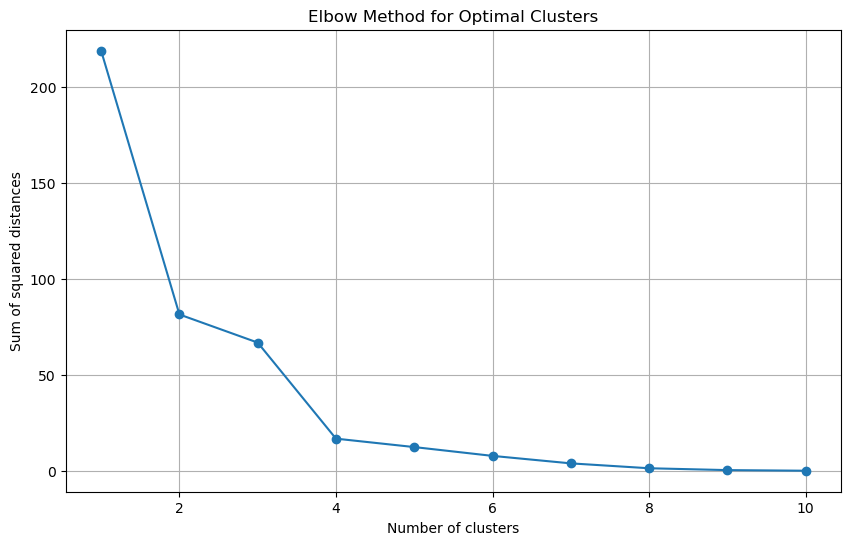

           DEP_DELAY  ARR_DELAY  CARRIER_DELAY  WEATHER_DELAY  NAS_DELAY  \
Cluster 1   7.623173   3.470134       2.716481       0.012409   1.076798   
Cluster 2  13.748206   9.374012       2.046459       0.027709   6.042333   
Cluster 3  10.943730   7.856789       2.773639       0.009061   4.465110   
Cluster 4  15.472027  11.501827       4.757380       0.008153   1.849873   

           SECURITY_DELAY  LATE_AIRCRAFT_DELAY  CANCELLED  
Cluster 1        0.021894             4.716132   0.015052  
Cluster 2        0.016447             5.767643   0.014493  
Cluster 3        0.007552             5.518349   0.024198  
Cluster 4        0.000000             9.765252   0.040484  


/var/folders/48/3359jr0n34v6fd5jftvl2dn00000gn/T/ipykernel_62474/996812784.py:56: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  date_cluster_group = flights_with_date.groupby(['FL_DATE', 'Cluster']).mean().reset_index()


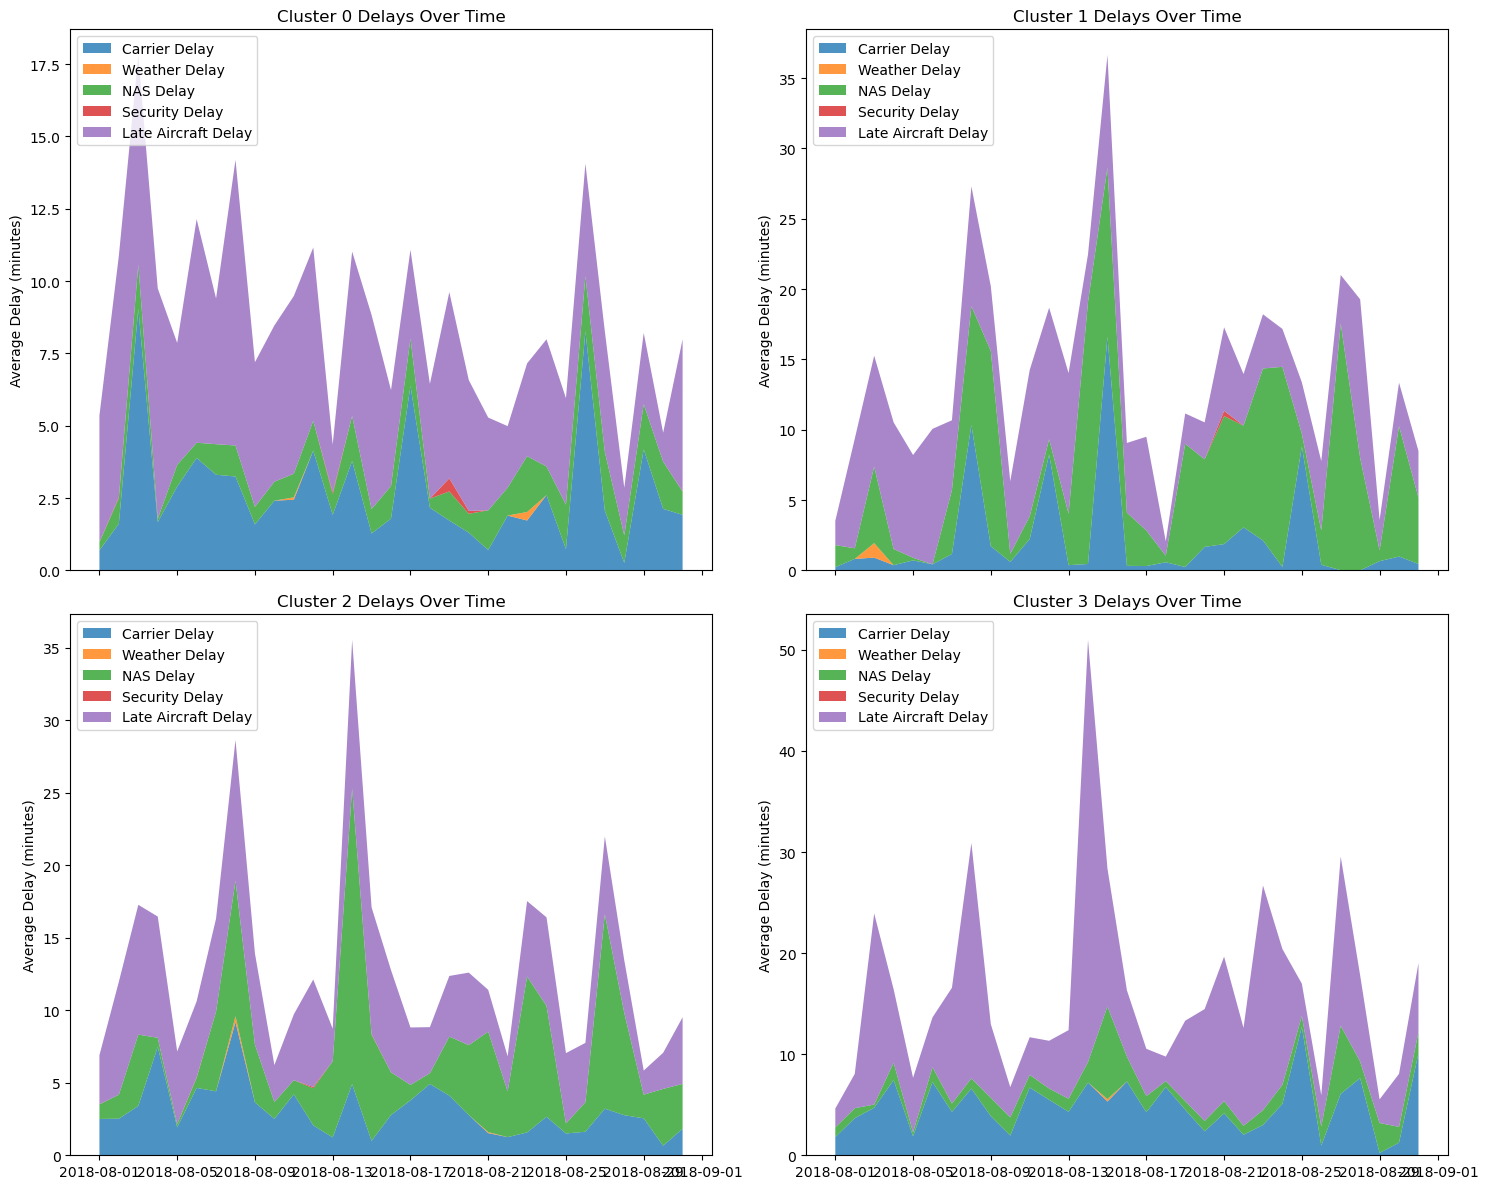

In [15]:
# Load the data
file_path = 'filtered_flight_data.csv'
flights_data = pd.read_csv(file_path)

# Clean and prepare the data
flights_data['FL_DATE'] = pd.to_datetime(flights_data['FL_DATE'])
relevant_columns = [
    'FL_DATE', 'ORIGIN', 'OP_CARRIER_AIRLINE_ID', 'DEP_DELAY', 'ARR_DELAY',
    'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'CANCELLED'
]
flights_data_filtered = flights_data[relevant_columns]
flights_data_filtered.fillna(0, inplace=True)  # Handling missing values by assuming no delay if data is missing

# Calculate average delays and cancellation rates for each airport
airport_delays = flights_data_filtered.groupby('ORIGIN').agg({
    'DEP_DELAY': 'mean',
    'ARR_DELAY': 'mean',
    'CARRIER_DELAY': 'mean',
    'WEATHER_DELAY': 'mean',
    'NAS_DELAY': 'mean',
    'SECURITY_DELAY': 'mean',
    'LATE_AIRCRAFT_DELAY': 'mean',
    'CANCELLED': 'mean'
}).reset_index()

# Clustering with K-means and determining the optimal number of clusters using the elbow method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(airport_delays.iloc[:, 1:])
    sse.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.grid(True)
plt.show()

# Applying K-means clustering with the chosen number of clusters (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42)
airport_delays['Cluster'] = kmeans.fit_predict(airport_delays.iloc[:, 1:])

# Analyzing and plotting cluster characteristics
cluster_centers = kmeans.cluster_centers_
columns = airport_delays.columns[1:-1]  # Exclude 'ORIGIN' and 'Cluster'
cluster_summary = pd.DataFrame(cluster_centers, columns=columns, index=[f'Cluster {i+1}' for i in range(4)])

# Printing cluster centers for insight
print(cluster_summary)

# Preparing area charts for delays over time by cluster
flights_with_date = flights_data_filtered.merge(airport_delays[['ORIGIN', 'Cluster']], on='ORIGIN', how='left')
date_cluster_group = flights_with_date.groupby(['FL_DATE', 'Cluster']).mean().reset_index()

# Area Chart for each cluster
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12), sharex=True)
clusters = sorted(date_cluster_group['Cluster'].unique())

for ax, cluster in zip(axes.flatten(), clusters):
    subset = date_cluster_group[date_cluster_group['Cluster'] == cluster]
    ax.stackplot(subset['FL_DATE'], subset['CARRIER_DELAY'], subset['WEATHER_DELAY'], subset['NAS_DELAY'], subset['SECURITY_DELAY'], subset['LATE_AIRCRAFT_DELAY'],
                 labels=['Carrier Delay', 'Weather Delay', 'NAS Delay', 'Security Delay', 'Late Aircraft Delay'],
                 alpha=0.8)
    ax.set_title(f'Cluster {cluster} Delays Over Time')
    ax.set_ylabel('Average Delay (minutes)')
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

### Cluster 1: "High Efficiency, Low Impact"

### Cluster 2: "Moderate Delays, Controlled Impact"

### Cluster 3: "Average Performance"

### Cluster 4: "High Delays and Cancellations"

<hr style="border:4px solid #000"/>

# 3. Shortest Path Analysis (Graph Algorithms)

In [16]:
# Load data from the CSV file
df = pd.read_csv('August 2018 Nationwide.csv')

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph from DataFrame. Each edge has a weight, which is the actual flying time.
for idx, row in df.iterrows():
    if pd.notna(row['ACTUAL_ELAPSED_TIME']):  # Ensure there's a valid flying time
        G.add_edge(row['ORIGIN'], row['DEST'], weight=row['ACTUAL_ELAPSED_TIME'])

# Define the airports for the route calculation
airport_a = 'JFK'  # Example starting airport
airport_b = 'LAX'  # Example destination airport

# Initialize a counter and path generator
try:
    path_generator = nx.shortest_simple_paths(G, source=airport_a, target=airport_b, weight='weight')
    shortest_time = None  # To store the shortest path time for reference
    for i in range(3):  # Fetch the top three shortest paths
        path = next(path_generator)
        total_time = sum(G[u][v]['weight'] for u, v in zip(path[:-1], path[1:]))
        if i == 0:
            shortest_time = total_time  # Set the first path time as the shortest
        else:
            time_difference = total_time - shortest_time
            print(f"Difference in time from shortest path for path {i+1}: {time_difference} minutes")
        print(f"Shortest path {i+1}: {path}")
        print("Total flying time:", total_time, "minutes")
except StopIteration:
    print("Less than three paths were found.")
except nx.NetworkXNoPath:
    print(f"No path found between {airport_a} and {airport_b}")

Shortest path 1: ['JFK', 'LAX']
Total flying time: 354.0 minutes
Difference in time from shortest path for path 2: 30.0 minutes
Shortest path 2: ['JFK', 'IND', 'LAX']
Total flying time: 384.0 minutes
Difference in time from shortest path for path 3: 30.0 minutes
Shortest path 3: ['JFK', 'CLE', 'LAX']
Total flying time: 384.0 minutes


<hr style="border:4px solid #000"/>

# 4. Connect all airports in a State (California) with Carrier Delay as weights using Minimum Spanning Tree (Kruskal's)

## (Graph Algorithms)

In [17]:
# Loading the dataset
flights = pd.read_csv('August 2018 Nationwide.csv')

#### Filter the data to include only California airports

In [18]:
# List of airport codes to filter by
airport_codes = ['BUR', 'LGB', 'LAX', 'OAK', 'ONT', 'SMF', 'SAN', 'SFO', 'SJC', 'SNA']
 
# Filter data where either the origin or destination airport is in the airport_codes list
filtered_df = flights[flights['ORIGIN'].isin(airport_codes) & flights['DEST'].isin(airport_codes)]

In [19]:
# Fill missing values with 0 (delays)
filtered_df.fillna(0)

,FL_DATE,OP_CARRIER_AIRLINE_ID,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 28
1087,2018-08-01,21167,N201NN,6005,12892,1289208,32575,LAX,14893,1489302,33192,SMF,700,653.0,-7.0,0.0,824.0,-4.0,0.0,0.0,0,88.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0
1088,2018-08-01,21167,N201NN,6005,14893,1489302,33192,SMF,12892,1289208,32575,LAX,900,851.0,-9.0,0.0,1038.0,-8.0,0.0,0.0,0,106.0,107.0,0.0,0.0,0.0,0.0,0.0,0.0
1092,2018-08-01,21167,N218NN,6010,12892,1289208,32575,LAX,14893,1489302,33192,SMF,1110,1104.0,-6.0,0.0,1227.0,-13.0,0.0,0.0,0,90.0,83.0,0.0,0.0,0.0,0.0,0.0,0.0
1093,2018-08-01,21167,N218NN,6010,14893,1489302,33192,SMF,12892,1289208,32575,LAX,1310,1305.0,-5.0,0.0,1436.0,-12.0,0.0,0.0,0,98.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0
1094,2018-08-01,21167,N209NN,6011,12892,1289208,32575,LAX,14831,1483106,32457,SJC,705,704.0,-1.0,0.0,816.0,0.0,0.0,0.0,0,71.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701267,2018-08-31,19687,N630QX,2550,14831,1483106,32457,SJC,10800,1080003,32575,BUR,635,631.0,-4.0,0.0,744.0,-6.0,0.0,0.0,0,75.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0
701268,2018-08-31,19687,N622QX,2552,14831,1483106,32457,SJC,10800,1080003,32575,BUR,1923,2003.0,40.0,40.0,2108.0,30.0,30.0,0.0,0,75.0,65.0,0.0,0.0,0.0,0.0,30.0,0.0
701319,2018-08-31,19687,N630QX,2810,10800,1080003,32575,BUR,14831,1483106,32457,SJC,830,824.0,-6.0,0.0,939.0,-5.0,0.0,0.0,0,74.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0
701321,2018-08-31,19687,N622QX,2812,10800,1080003,32575,BUR,14831,1483106,32457,SJC,2118,2143.0,25.0,25.0,2252.0,20.0,20.0,0.0,0,74.0,69.0,0.0,0.0,0.0,0.0,20.0,0.0


In [20]:
# Take areas where Carrier Delay > 0
filtered_df = filtered_df[filtered_df['CARRIER_DELAY']>0]

#### Kruskal's algorithm to identify the best method to connect all California airports with Carrier Delay as weights

Total Delay in Full Network: 562.0
Total Delay in MST: 36.0


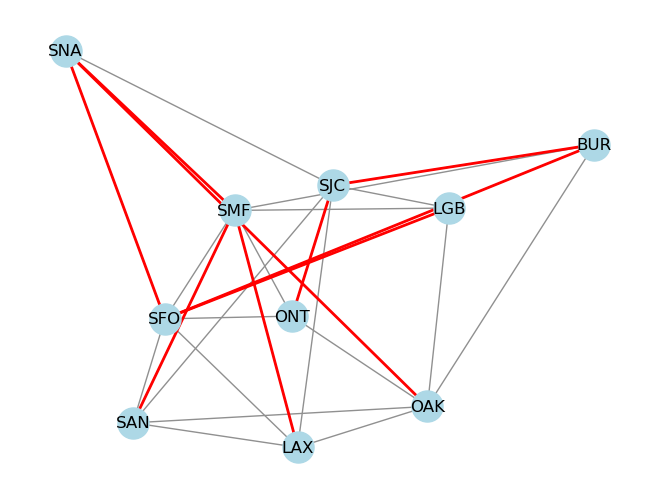

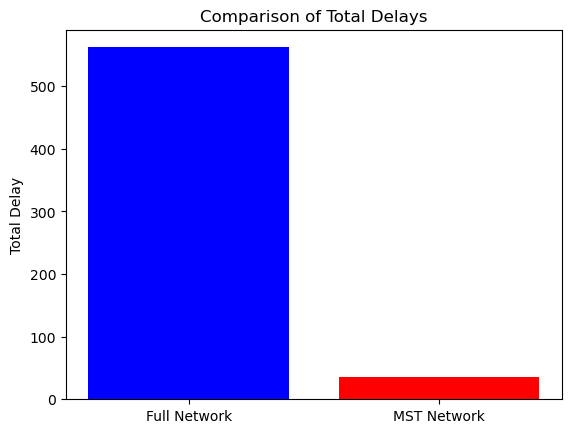

In [21]:
# Create a graph for the filtered data
G_filtered = nx.Graph()
for index, row in filtered_df.iterrows():
    G_filtered.add_edge(row['ORIGIN'], row['DEST'], weight=abs(row['CARRIER_DELAY']))

# Compute the MST using Kruskal's algorithm for the filtered graph
mst_filtered = nx.minimum_spanning_tree(G_filtered, algorithm='kruskal')

# Calculate total delay in the full filtered network
total_delay_full = sum(weight for (u, v, weight) in G_filtered.edges(data='weight'))

# Calculate total delay in the MST
total_delay_mst = sum(weight for (u, v, weight) in mst_filtered.edges(data='weight'))

# Output the total delays for comparison
print(f"Total Delay in Full Network: {total_delay_full}")
print(f"Total Delay in MST: {total_delay_mst}")

# Plotting the filtered graph with MST
pos = nx.spring_layout(G_filtered)  # positions for all nodes
nx.draw(G_filtered, pos, with_labels=True, node_color='lightblue', edge_color='#909090', node_size=500)
nx.draw_networkx_edges(mst_filtered, pos, edge_color='red', width=2)
# plt.title(f'Flight Network with MST for {state}')
plt.show()

# Plotting the comparison of delays
delays = [total_delay_full, total_delay_mst]
labels = ['Full Network', 'MST Network']
colors = ['blue', 'red']
plt.bar(labels, delays, color=colors)
plt.ylabel('Total Delay')
plt.title('Comparison of Total Delays')
plt.show()

 **Grey lines:** Current connections between airports (California)
 
 **Red lines:** Suggested connections between airports (California) using Kruskal's

**Building the Filtered Graph:**
1. A new graph G_filtered is initialized.
2. The script iterates through filtered_df, which is presumably a pandas DataFrame containing filtered flight data with columns 'ORIGIN', 'DEST', and 'CARRIER_DELAY'.
3. For each row in filtered_df, an edge is added between the origin and destination airports with a weight equal to the absolute value of the carrier delay (abs(row['CARRIER_DELAY'])). This ensures that delay values are positive, which is typical for weights in graph algorithms.

**Computing the Minimum Spanning Tree (MST):**
1. The Minimum Spanning Tree (MST) of G_filtered is computed using Kruskal's algorithm. Kruskal's algorithm is a greedy algorithm that finds the minimum spanning tree for a connected weighted graph, ensuring that the tree includes every vertex with the minimal possible total edge weight.

**Calculating Total Delays:**
1. total_delay_full: Calculates the total delay in the full network by summing the weights of all edges in G_filtered.
2. total_delay_mst: Calculates the total delay in the MST by summing the weights of all edges in the MST (mst_filtered).

**Outputting Total Delays:**
1. Prints the total delays for the full network and the MST, providing a comparison to see how much delay is reduced when using the MST instead of the full network.

**Plotting the Graph and MST:**
Uses nx.spring_layout(G_filtered) to generate positions for all nodes in a visually appealing way.
Plots G_filtered using a standard visualization with labels and node colors.
Overlays the MST on the same plot with edges colored red to distinguish them from the full network's edges.

**Plotting Delay Comparison:**
Creates a bar chart comparing the total delays of the full network and the MST. This visual comparison helps to illustrate the effectiveness of the MST in minimizing the total delay across the network.

### Results

**Significant Reduction in Total Delay:** The total delay in the full network is 562 units, while in the MST it is significantly reduced to only 36 units. This shows a drastic reduction in total delay when the network is optimized to only include the most necessary connections, as represented by the MST.

**Efficiency of MST:** The MST effectively minimizes the cumulative weight (in this case, delay) of the edges included in the tree. This optimization demonstrates the strength of using MST in network analysis, particularly in contexts where it's critical to minimize a certain cost (like time or resource expenditure).

**Implications for Network Planning:** In practical terms, especially in transportation and logistics (like airline routing), constructing networks according to principles similar to those of MST can lead to significant efficiency gains. By only maintaining essential routes that offer the most direct and least delayed connections, airlines could potentially reduce operational delays and improve overall service quality.

**Visualization and Decision Making:** The visual representation provided by the network graph and the bar chart offers clear insights into how network optimization affects performance metrics like delays. This can be extremely useful for decision-makers in planning and optimizing operational networks.

<hr style="border:4px solid #000"/>

# 5. Optimization of Flight Schedules to Minimize Delay Penalties (Linear Programming)

In [22]:
# Loading the dataset
data = pd.read_csv('filtered_flight_data.csv')

# Convert FL_DATE to datetime
data['FL_DATE'] = pd.to_datetime(data['FL_DATE'])

#### User Input
Here we take the **Origin airport  A as LAX** and **Destinaion Airport B as SFO** for instance. This can be altered if we want to see the optimised schedule for other routes

In [23]:
# User inputs for origin and destination
origin_input = 'LAX'
destination_input = 'SFO'

There are delays associated with the flights which are essential in understanding as there is very high costs associated with flight delays for a company. In order to reduce the delays by penalising it, we have created a penalty system according to the delays incurred by a flight.

The penalty costs assigned to different types of flight delays quantify the financial impact of inefficiencies. High penalties for carrier and security delays encourage better management and operational efficiency, while moderate penalties for weather and NAS delays recognize partial airline control over these factors.

In [24]:
# Fill missing values and calculate penalties
data.fillna({'CARRIER_DELAY': 0, 'WEATHER_DELAY': 0, 'NAS_DELAY': 0, 'SECURITY_DELAY': 0, 'LATE_AIRCRAFT_DELAY': 0}, inplace=True)
penalty_costs = {'CARRIER_DELAY': 100, 'WEATHER_DELAY': 75, 'NAS_DELAY': 50, 'SECURITY_DELAY': 200, 'LATE_AIRCRAFT_DELAY': 60}
data['TOTAL_PENALTY'] = sum(data[col] * cost for col, cost in penalty_costs.items())

#### Calculating the total penalty before any optimzationa as per current schedule

In [25]:
# Filter for the specific route
route_data = data[(data['ORIGIN'] == origin_input) & (data['DEST'] == destination_input)]
total_penalty_cost_before = route_data['TOTAL_PENALTY'].sum()

Now, we try to optimise the totals schedule of daily flights for a month(August 2018 for instance) to see when airline companies have targets to reduce delay based penalties, what is the best way to created an optimised schedule that will help them achieve their targets.

To enhance the efficiency of flight schedules on a specific route for August 2018, we aimed to minimize delay-related penalties by at least 20% while maximizing the number of flights. This strategy helps airlines meet their goals of reducing operational disruptions and costs, maintaining high levels of service. By employing linear programming, we established an optimization model that quantifies and aims to reduce penalties associated with different types of delays, such as those caused by the carrier, weather, or airport systems. Successfully optimizing the schedule not only meets financial and operational objectives but also improves customer satisfaction by ensuring more dependable flights. This refined approach provides airlines with a strategic framework to fine-tune their operations, achieving a more cost-effective and reliable flight schedule.


In [26]:
# Create the LP problem
problem = pulp.LpProblem("Maximize_Flights_Reduce_Penalties", pulp.LpMaximize)

# Decision Variables
flight_vars = {}
for date in route_data['FL_DATE'].unique():
    daily_flights = route_data[route_data['FL_DATE'] == date]
    date_str = pd.Timestamp(date).strftime('%Y-%m-%d')
    flight_vars[date] = pulp.LpVariable.dicts(f"Flight_{date_str}", daily_flights.index, cat='Binary')

# Objective Function
problem += pulp.lpSum(flight_vars[date][i] for date in route_data['FL_DATE'].unique() for i in flight_vars[date])

# Constraints: Ensure penalty reduction by at least 20%
target_penalty = total_penalty_cost_before * 0.8  # 20% reduction
problem += pulp.lpSum([flight_vars[date][i] * route_data.at[i, 'TOTAL_PENALTY'] for date in route_data['FL_DATE'].unique() for i in flight_vars[date]]) <= target_penalty

# Solve the problem
problem.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/harsh/anaconda3/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/48/3359jr0n34v6fd5jftvl2dn00000gn/T/6dfc537a4b8449aa89da27ee569ec734-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/48/3359jr0n34v6fd5jftvl2dn00000gn/T/6dfc537a4b8449aa89da27ee569ec734-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 5480 RHS
At line 5482 BOUNDS
At line 7135 ENDATA
Problem MODEL has 1 rows, 1652 columns and 517 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1624.3 - 0.00 seconds
Cgl0004I processed model has 1 rows, 258 columns (258 integer (166 of which binary)) and 258 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 1 integers unsatisfied sum - 0.298701
Cbc0038I Solution found of -1624
Cbc003

1

In [27]:
print("Solver Status:", pulp.LpStatus[problem.status])
for date in route_data['FL_DATE'].unique():
    date_str = pd.Timestamp(date).strftime('%Y-%m-%d')
    print(f"--- Flights for {date_str} ---")
    for i in flight_vars[date]:
        if flight_vars[date][i].value() == 1:
            print(f"Flight ID {i} included in the schedule with penalty {route_data.at[i, 'TOTAL_PENALTY']:.2f}")
    print("\n")

Solver Status: Optimal
--- Flights for 2018-08-01 ---
Flight ID 6 included in the schedule with penalty 0.00
Flight ID 8 included in the schedule with penalty 0.00
Flight ID 12 included in the schedule with penalty 0.00
Flight ID 16 included in the schedule with penalty 0.00
Flight ID 18 included in the schedule with penalty 0.00
Flight ID 25 included in the schedule with penalty 0.00
Flight ID 27 included in the schedule with penalty 0.00
Flight ID 30 included in the schedule with penalty 0.00
Flight ID 39 included in the schedule with penalty 0.00
Flight ID 41 included in the schedule with penalty 0.00
Flight ID 50 included in the schedule with penalty 0.00
Flight ID 51 included in the schedule with penalty 0.00
Flight ID 52 included in the schedule with penalty 0.00
Flight ID 53 included in the schedule with penalty 0.00
Flight ID 58 included in the schedule with penalty 0.00
Flight ID 59 included in the schedule with penalty 3500.00
Flight ID 62 included in the schedule with penalt

#### Above is the optimized schedule that airline operators can use which reduces their delay based penalties as per below mentioned metrics

In [28]:
# Filter for the specific route
route_data = data[(data['ORIGIN'] == origin_input) & (data['DEST'] == destination_input)]
total_flights_before = len(route_data)  # Count flights before optimization

# Calculate total penalty cost after optimization and count flights after optimization
total_flights_after = sum(flight_vars[date][i].value() for date in route_data['FL_DATE'].unique() for i in flight_vars[date])
total_penalty_cost_after = pulp.value(pulp.lpSum([flight_vars[date][i] * route_data.at[i, 'TOTAL_PENALTY'] for date in route_data['FL_DATE'].unique() for i in flight_vars[date]]))
flights_reduction = total_flights_before - total_flights_after
penalty_reduction = total_penalty_cost_before - total_penalty_cost_after
percentage_change = (penalty_reduction / total_penalty_cost_before * 100) if total_penalty_cost_before > 0 else 0


print(f"Total Flights before optimization: {total_flights_before}")
print(f"Total Flights after optimization: {int(total_flights_after)}")
print(f"Reduction in Flights in a month: {flights_reduction}")
print(f"Total Penalty Cost before optimization: ${total_penalty_cost_before:.2f}")
print(f"Total Penalty Cost after optimization: ${total_penalty_cost_after:.2f}")
print(f"Reduction in Penalty: ${penalty_reduction:.2f} ({percentage_change:.2f}%)")

Total Flights before optimization: 1652
Total Flights after optimization: 1624
Reduction in Flights in a month: 28.0
Total Penalty Cost before optimization: $1838950.00
Total Penalty Cost after optimization: $1468400.00
Reduction in Penalty: $370550.00 (20.15%)


## Flight Schedule Optimization Analysis

### Optimization Results Summary

The optimization model yielded the following results for the month of August 2018:

- **Total Flights Before Optimization:** 1,652
- **Total Flights After Optimization:** 1,624
- **Reduction in Flights:** 28 flights

This minimal reduction suggests that the optimization targeted flights contributing disproportionately to delays, rather than broadly reducing the number of flights.

- **Total Penalty Cost Before Optimization:** \$1,838,950
- **Total Penalty Cost After Optimization:** \$1,468,400
- **Reduction in Penalty Costs:** \$370,550 (20.15%)

### Insights Derived from Optimization

1. **Efficiency in Operation**: The slight decrease in total flights coupled with a significant reduction in penalty costs indicates a targeted approach in the optimization process. Flights that were frequently delayed by controllable factors were likely prioritized, thus maintaining service levels while enhancing operational efficiency.

2. **Cost Management**: The substantial decrease in penalty costs highlights the effectiveness of the optimization. This demonstrates that airlines can significantly reduce operational costs related to delays by strategically managing and adjusting schedules.

3. **Strategic Operational Benefits**: The results underscore the potential for airlines to improve profitability and operational performance by applying data-driven strategies to their scheduling practices. It also showcases the capability to maintain customer service quality while achieving cost efficiencies.

### Conclusion

The flight schedule optimization for August 2018 exemplifies how airlines can leverage optimization techniques to balance service quality with operational and financial improvements. This approach not only helps in reducing delay-related costs but also supports airlines in ma


<hr style="border:4px solid #000"/>